In [ ]:
from PIL import Image, ImageDraw, ImageFont
import random
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from sklearn.model_selection import train_test_split
%matplotlib inline

In [ ]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


# 1. Самостоятельно сгенерируем по 820 картинок размером 100х100 пикселей (px) для каждой из цифр: 0, 1, 3, 8 следующим образом (800 – тренировочная выборка, 20 – тестовая выборка № 1):
- фон картинки белый,
- цифра: ширина – 20 px, высота – 50 px, цвет линии – черный, цифра целиком помещается в картинку, цифра находится в случайном месте на картинке,
- на изображении цифра расположена так, что ее вертикальная ось параллельна оси ординат (вертикальное положение) или оси абсцисс (горизонтальное положение),
- тренировочная выборка содержит 400 изображений каждой цифры в горизонтальном положении и 400 изображений каждой цифры в вертикальном положении,
- тестовая выборка содержит 10 изображений каждой цифры в горизонтальном положении и 10 изображений каждой цифры в вертикальном положении,


In [ ]:
rotation_matrix = cv2.getRotationMatrix2D((100/2, 100/2), 90, 1)
X_train = []
y_train = []

X_test = []
y_test = []

def generate_images(cnt):
    digits = [0, 1, 3, 8]

    for digit in digits:
        for i in range(cnt+21):
            img = np.ones((100, 100), dtype=np.uint8) * 255
            x_pos = np.random.randint(35, 60)
            y_pos = np.random.randint(45, 75)
            cv2.putText(img, str(digit), (x_pos, y_pos), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 0), 2)

            if i < cnt and i % 2==0:
                img = np.array(img) / 255.0
                X_train.append(img)
                y_train.append(digit)

            elif i < cnt and i % 2!=0:
                img = cv2.warpAffine(img, rotation_matrix, (100, 100))
                img = np.array(img) / 255.0
                X_train.append(img)
                y_train.append(digit)


            if i > cnt and i % 2==0:
                img = np.array(img) / 255.0
                X_test.append(img)
                y_test.append(digit)
            elif i > cnt and i % 2!=0:
                img = cv2.warpAffine(img, rotation_matrix, (100, 100))
                img = np.array(img) / 255.0
                X_test.append(img)
                y_test.append(digit)


generate_images(100)


#### Выведем результат

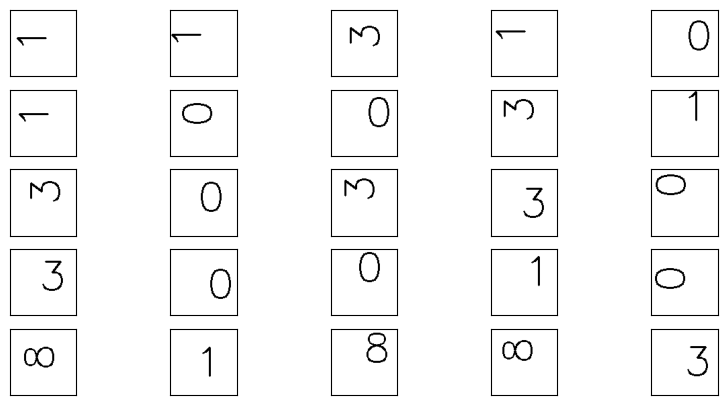

In [ ]:
plt.figure(figsize=(10, 5))
for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(random.choice(X_train), cmap="gray")

plt.show()

# 2. Создадим новые тестовые картинки, полученные путем добавления черных пикселей (шум) в случайно выбранные места сгенерированных тестовых картинок:
- 20 px (тестовая выборка № 2),
- 50 px (тестовая выборка № 3),
- 100 px (тестовая выборка № 4),
- 200 px (тестовая выборка № 5).


In [ ]:
X_test_noisy = []
y_test_noisy = []

def add_noise(image, noise_size):

    for i in range(noise_size):
        x_noise = np.random.randint(0, 100)
        y_noise = np.random.randint(0, 100)
        image[x_noise, y_noise] = 0

    return image

def create_noisy_test_images():
    noise_sizes = [20, 50, 100, 200]
    for idx, img in enumerate(X_test):
        for size in noise_sizes:
            noisy_img = img.copy()
            noisy_img = add_noise(noisy_img, size)
            noisy_img = np.array(noisy_img) / 255.0
            X_test_noisy.append(noisy_img)
            y_test_noisy.append(y_test[idx])

# def create_noisy_test_images():
#     noise_sizes = [20, 50, 100, 200]
#     cnt = 0
#     for img in X_test:
#           noisy_img = img.copy()
#           noisy_img = add_noise(noisy_img, 20)
#           noisy_img = np.array(noisy_img) / 255.0
#           X_test_noisy.append(noisy_img)
#           y_test_noisy.append(y_test[cnt])
#           cnt += 1
create_noisy_test_images()

#### Проверим что получилось

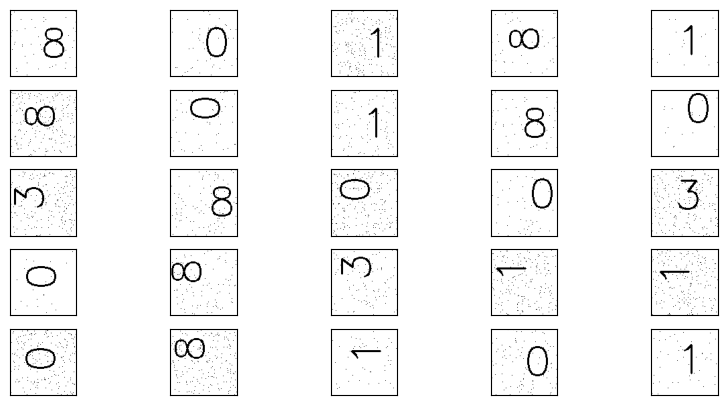

In [ ]:
plt.figure(figsize=(10, 5))
for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(random.choice(X_test_noisy),cmap="gray")
plt.show()

# Уточним задачу:
1. На вход подается тренировочное множество: по 800 картинок каждой цифры.
2.	Из тренировочного множества выделяется часть картинок (10–20%), на валидационное множество, в котором должны присутствовать цифры в вертикальном и горизонтальном положении.
3.	Протестировать адекватность модели на всех тестовых выборках № 1, № 2, № 3, № 4, № 5, фиксируя при этом точность (accuracy) классификации.
4.	Повторить пункты 1)–3), изменив объем тренировочной выборки до 600, 400, 200, 100 картинок каждой цифры.



# 1) Тренировочная выборка 800 картинок

#### Нормализуем выборки и изменим размерность

In [ ]:
def shuffle_lists(list1, list2):
    combined_list = list(zip(list1, list2))
    random.shuffle(combined_list)
    shuffled_list1, shuffled_list2 = zip(*combined_list)
    return list(shuffled_list1), list(shuffled_list2)

In [ ]:

X_train, y_train = shuffle_lists(X_train, y_train)
X_test, y_test = shuffle_lists(X_test, y_test)
X_test_noisy, y_test_noisy = shuffle_lists(X_test_noisy, y_test_noisy)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train , test_size=0.2, random_state=42)

X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)
X_test_noisy = np.array(X_test_noisy)

X_train = np.expand_dims(X_train, axis=3)
X_val = np.expand_dims(X_val, axis=3)
X_test = np.expand_dims(X_test, axis=3)
X_test_noisy = np.expand_dims(X_test_noisy, axis=3)

#### Приведём к numpy массиву

In [ ]:
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)
y_test_noisy = np.array(y_test_noisy)

# # Обновление значений меток классов для цифры "8" на "3"
y_train[y_train == 8] = 2
y_val[y_val == 8] = 2
y_test[y_test == 8] = 2
y_test_noisy[y_test_noisy == 8] = 2

num_classes = 4


y_train_cat = keras.utils.to_categorical(y_train, num_classes)
y_val_cat = keras.utils.to_categorical(y_val, num_classes)
y_test_cat = keras.utils.to_categorical(y_test, num_classes)
y_test_noisy_cat = keras.utils.to_categorical(y_test_noisy, num_classes)

In [ ]:
y_test_noisy

array([3, 1, 2, 0, 2, 3, 3, 1, 1, 2, 1, 0, 2, 3, 3, 3, 1, 0, 2, 2, 3, 1,
       0, 1, 2, 1, 1, 2, 2, 1, 3, 1, 2, 0, 1, 3, 3, 3, 1, 0, 1, 1, 0, 1,
       1, 3, 1, 1, 3, 2, 3, 2, 3, 1, 3, 1, 3, 1, 1, 2, 2, 2, 1, 1, 0, 3,
       0, 0, 2, 2, 1, 3, 3, 2, 2, 2, 2, 1, 0, 3, 3, 0, 0, 3, 3, 2, 0, 2,
       1, 1, 2, 0, 0, 2, 3, 1, 0, 1, 1, 0, 1, 2, 3, 2, 3, 2, 0, 1, 2, 0,
       2, 0, 0, 1, 0, 3, 2, 0, 0, 3, 3, 3, 0, 0, 3, 0, 3, 1, 1, 0, 0, 0,
       3, 3, 2, 0, 1, 1, 3, 2, 0, 3, 0, 2, 0, 1, 2, 0, 0, 2, 3, 0, 3, 2,
       1, 2, 2, 3, 0, 1, 2, 3, 2, 2, 3, 1, 0, 3, 2, 0, 2, 1, 2, 0, 3, 2,
       2, 2, 3, 2, 1, 3, 2, 1, 2, 2, 3, 1, 3, 0, 0, 1, 3, 1, 2, 0, 0, 2,
       3, 3, 0, 0, 3, 0, 0, 1, 3, 0, 2, 0, 0, 2, 1, 1, 1, 3, 2, 1, 0, 2,
       1, 1, 1, 3, 3, 0, 1, 0, 0, 3, 0, 2, 1, 1, 0, 1, 3, 2, 3, 1, 3, 0,
       0, 1, 2, 3, 0, 0, 0, 1, 1, 1, 2, 2, 3, 0, 3, 0, 0, 3, 0, 2, 0, 0,
       3, 0, 3, 2, 3, 0, 1, 2, 1, 1, 1, 0, 3, 0, 3, 1, 2, 2, 3, 1, 3, 2,
       2, 2, 3, 2, 1, 0, 2, 1, 0, 2, 0, 1, 2, 1, 0,

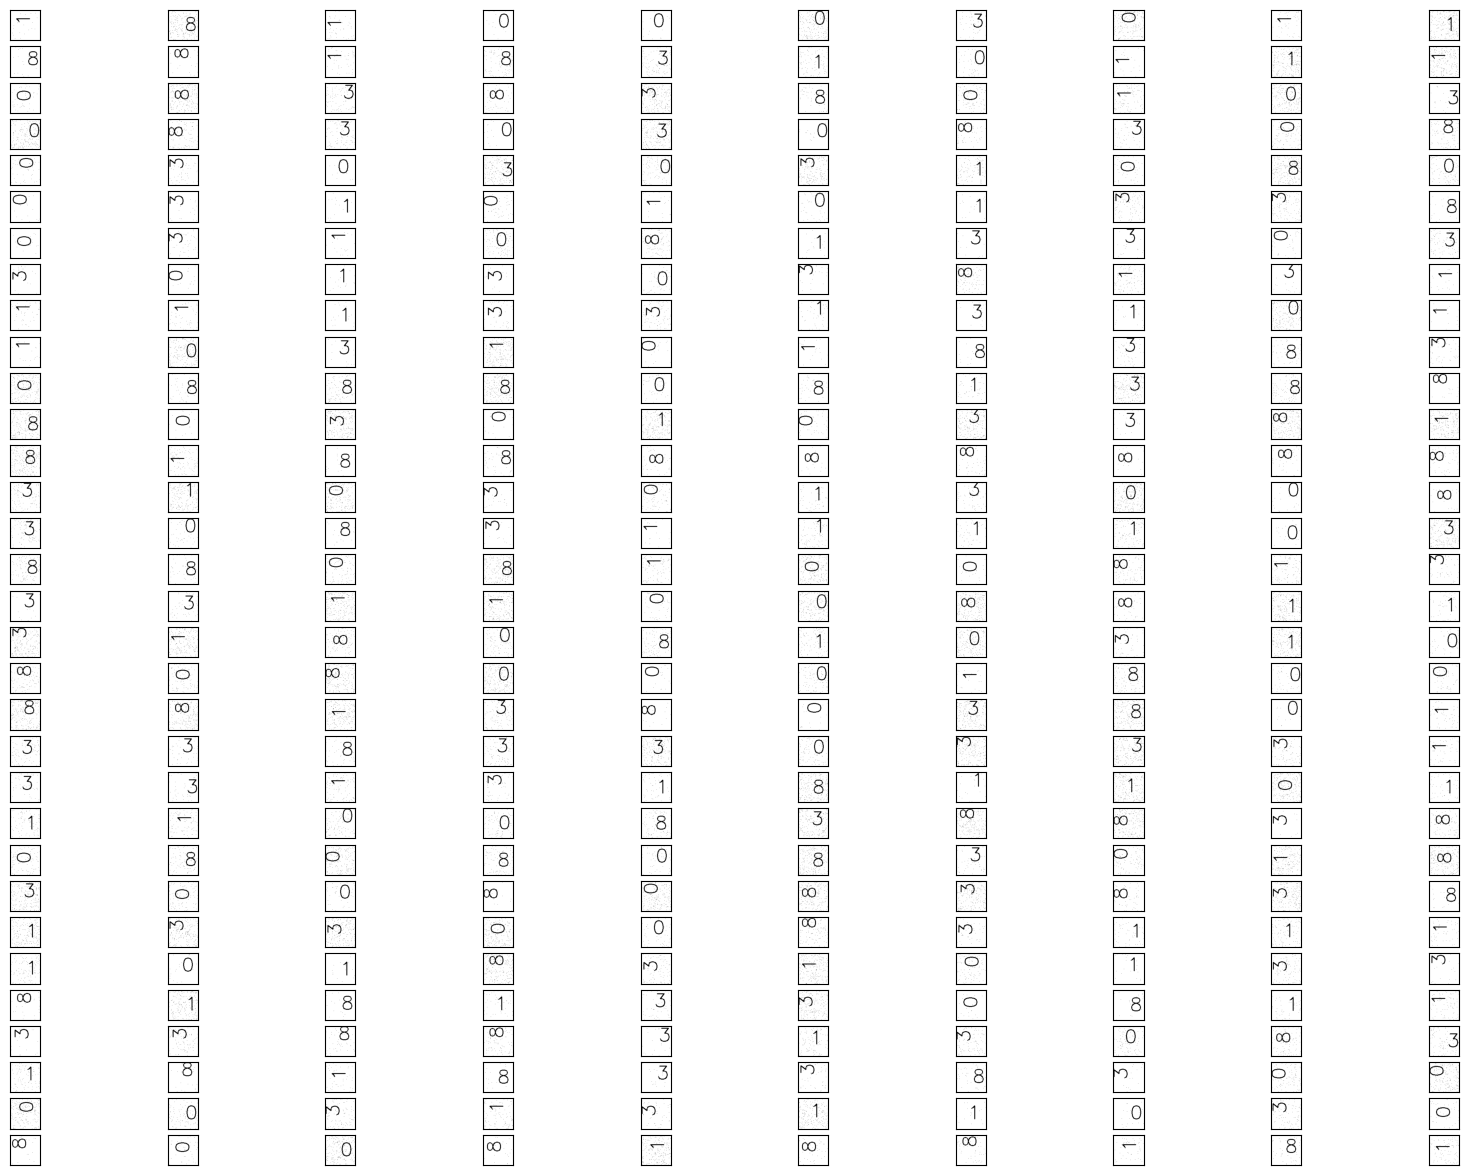

In [ ]:
plt.figure(figsize=(20, 15))
for i in range(0,320):
  plt.subplot(32, 10, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(X_test_noisy[i],cmap="gray")
plt.show()

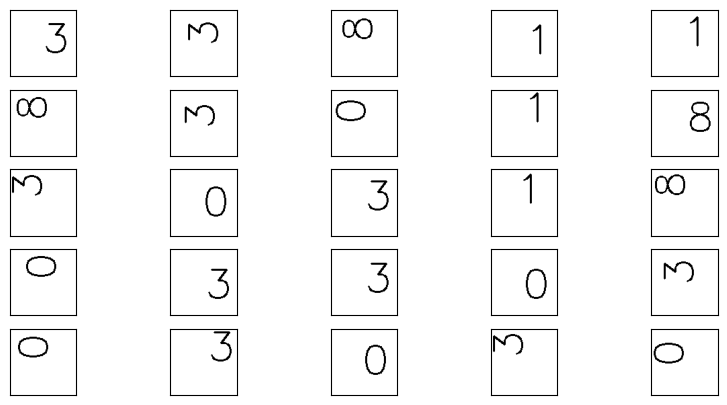

array([3, 3, 4, 1, 1, 4, 3, 0, 1, 4, 3, 0, 3, 1, 4, 0, 3, 3, 0, 3, 0, 3,
       0, 3, 0])

In [ ]:
plt.figure(figsize=(10, 5))
for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(X_train[i],cmap="gray")
plt.show()
y_train[:25]

#### Сформируем модель cо следующей структурой:
- Convolution layer 3x3
- Max-polling layer 2x2
- Convolution layer 3x3
- Max-polling layer 2x2
- Flatten layer,
- Dense 128 layer activation='relu',
- Dense 64 layer activation='relu',
- Dense 4 layer activation='softmax',

In [ ]:
num_filters = 32
filter_size = 3
pool_size = 2

model = keras.Sequential([
  Conv2D(num_filters, filter_size, activation='relu', input_shape=(100, 100, 1)),
  MaxPooling2D(pool_size=pool_size),
  Conv2D(num_filters*2, filter_size, activation='relu'),
  MaxPooling2D(pool_size=pool_size),
  Flatten(),
  Dense(128, activation='relu'),
  Dense(64, activation='relu'),
  #Dropout(0.5),
  Dense(4, activation='softmax'),
])


#### Прежде чем приступить к обучению необходимо добавить к модели оптимизатор, функцию ошибки и метрики

In [ ]:
model.compile(optimizer='Adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 98, 98, 32)        320       
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 49, 49, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 23, 23, 64)        0         
 ng2D)                                                           
                                                                 
 flatten_5 (Flatten)         (None, 33856)             0         
                                                                 
 dense_15 (Dense)            (None, 128)              

In [ ]:
model.fit(X_train, y_train_cat, epochs=10, validation_data=(X_val, y_val_cat))

Epoch 1/10
10/10 [==============================] - 2s 33ms/step - loss: 1.5832 - accuracy: 0.2844 - val_loss: 1.3982 - val_accuracy: 0.2375
Epoch 2/10
10/10 [==============================] - 0s 16ms/step - loss: 1.2870 - accuracy: 0.3812 - val_loss: 1.2640 - val_accuracy: 0.4000
Epoch 3/10
10/10 [==============================] - 0s 15ms/step - loss: 1.0002 - accuracy: 0.7000 - val_loss: 1.0642 - val_accuracy: 0.5750
Epoch 4/10
10/10 [==============================] - 0s 14ms/step - loss: 0.6656 - accuracy: 0.7656 - val_loss: 0.8486 - val_accuracy: 0.7125
Epoch 5/10
10/10 [==============================] - 0s 14ms/step - loss: 0.4062 - accuracy: 0.8969 - val_loss: 0.7355 - val_accuracy: 0.7750
Epoch 6/10
10/10 [==============================] - 0s 14ms/step - loss: 0.2319 - accuracy: 0.9250 - val_loss: 0.6167 - val_accuracy: 0.7750
Epoch 7/10
10/10 [==============================] - 0s 15ms/step - loss: 0.1445 - accuracy: 0.9594 - val_loss: 0.7195 - val_accuracy: 0.7875
Epoch 8/10
10

#### Тестовая выборка № 1

In [ ]:
model.evaluate(X_test, y_test_cat)

3/3 [==============================] - 0s 8ms/step - loss: 0.1684 - accuracy: 0.9375


[0.16841979324817657, 0.9375]

#### Тестовая выборка № 2

In [ ]:
model.evaluate(X_test_noisy[:80], y_test_noisy_cat[:80])

3/3 [==============================] - 0s 5ms/step - loss: 10.7138 - accuracy: 0.2625


[10.713811874389648, 0.26249998807907104]

#### Тестовая выборка № 3

In [ ]:
model.evaluate(X_test_noisy[80:160], y_test_noisy_cat[80:160])

3/3 [==============================] - 0s 6ms/step - loss: 9.0096 - accuracy: 0.2250


[9.00956916809082, 0.22499999403953552]

#### Тестовая выборка № 4

In [ ]:
model.evaluate(X_test_noisy[160:240], y_test_noisy_cat[160:240])

3/3 [==============================] - 0s 6ms/step - loss: 9.5232 - accuracy: 0.2625


[9.523171424865723, 0.26249998807907104]

#### Тестовая выборка № 5

In [ ]:
model.evaluate(X_test_noisy[240:], y_test_noisy_cat[240:])

3/3 [==============================] - 0s 6ms/step - loss: 9.3680 - accuracy: 0.2500


[9.367952346801758, 0.25]